In [45]:


from google.colab import drive
drive.mount("/content/drive")
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import cuml
import cudf
plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'PingFang HK', 'Microsoft YaHei', 'SimSun']  # 优先级从左到右
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

df = pd.read_csv('drive/MyDrive/init.csv')

df.set_index('timestamp', inplace=True)






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 24.12.* libraries
Using Python 3.11.11 environment at: /usr
Audited 11 packages in 92ms

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://github.c

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'PingFang HK', 'Microsoft YaHei', 'SimSun']  # 优先级从左到右
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

df = pd.read_csv('data/init.csv')

df.set_index('timestamp', inplace=True)





In [46]:
def calculate_atr(df, period=14):
    # 计算三种价格范围
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())

    # 真实范围取最大值
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)

    # 使用 Wilder 的平滑方法计算 ATR
    atr = pd.Series(index=df.index, dtype=float)
    atr.iloc[period-1] = true_range[:period].mean()  # 第一个ATR值使用简单平均

    # 使用 Wilder 的平滑方法计算后续值
    for i in range(period, len(df)):
        atr.iloc[i] = (atr.iloc[i-1] * (period-1) + true_range.iloc[i]) / period

    return atr

# 计算 ATR
df['ATR'] = calculate_atr(df)
df['ATR_Pct'] = (df['ATR'] / df['close']) * 100

## 简易支撑压力 ##


In [ ]:
# 支撑位：最近N根K线的最低价（动态窗口）
def dynamic_support(data, window=30):
    return data['low'].rolling(window).min()

# 阻力位：最近N根K线的最高价（动态窗口）
def dynamic_resistance(data, window=30):
    return data['high'].rolling(window).max()

# 加入波动率调整
df['support'] = dynamic_support(df) * (1 - 0.1*df['ATR_Pct'])
df['resistance'] = dynamic_resistance(df) * (1 + 0.1*df['ATR_Pct'])

## 动量压缩比 ##

In [ ]:
def calculate_momentum_compression_ratio(dataframe, short_window, long_window):
    dataframe['Short_Term_Momentum'] = dataframe['close'].diff(periods=short_window)
    dataframe['Long_Term_Momentum'] = dataframe['close'].diff(periods=long_window)
    dataframe['Momentum_Compression_Ratio'] = dataframe['Short_Term_Momentum'] / dataframe['Long_Term_Momentum']
    return dataframe

# 设置参数，例如短期5分钟，长期15分钟
df = calculate_momentum_compression_ratio(df, short_window=5, long_window=15)


## 弹性 ##

In [ ]:
def calculate_elasticity_coefficient(dataframe, window):
    roll_max = dataframe['high'].rolling(window=window, min_periods=1).max()
    roll_min = dataframe['low'].rolling(window=window, min_periods=1).min()
    dataframe['Elasticity'] = (dataframe['close'] - roll_min) / (roll_max - roll_min)
    return dataframe

# 应用函数，例如使用14分钟作为窗口
df = calculate_elasticity_coefficient(df, window=14)


## 压力 ##

In [ ]:
def calculate_pressure_accumulation(dataframe):
    # 根据收盘价是否高于开盘价来决定多空力量
    dataframe['Pressure'] = np.where(dataframe['close'] > dataframe['open'],
                                     dataframe['volume'], -dataframe['volume'])
    # 累积多空力量
    dataframe['Cumulative_Pressure'] = dataframe['Pressure'].cumsum()

    return dataframe

# 应用函数到实际数据
df = calculate_pressure_accumulation(df)

#


## Hurst ##


In [ ]:
from hurst import compute_Hc

def calculate_fractal_dimension(dataframe, window):
    H, c, data = compute_Hc(dataframe['close'].values, kind='price', simplified=True)
    D = 2 - H
    return H, D

# 计算示例数据集的Hurst指数和分形维度
H, D = calculate_fractal_dimension(df, window=60)
print("Hurst指数:", H)
print("分形维度:", D)

Hurst指数: 0.5494223636011429
分形维度: 1.4505776363988572


## RSI ##


In [47]:


def calculate_rsi_wilder(df, period=14):
    # 计算价格变化
    delta = df['close'].diff()

    # 分别获取上涨和下跌
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    # Wilder's EMA 使用 alpha = 1/period
    # 首次计算简单平均值
    avg_gain = gain[:period].mean()
    avg_loss = loss[:period].mean()

    # 准备存放 RSI 的序列
    rsi_series = pd.Series(index=df.index, dtype=float)

    # 第一个 RSI 值
    rsi_series.iloc[period] = 100 - (100 / (1 + (avg_gain / avg_loss)))

    # 使用 Wilder 的平滑方法计算后续值
    for i in range(period + 1, len(df)):
        avg_gain = ((avg_gain * (period - 1)) + gain.iloc[i]) / period
        avg_loss = ((avg_loss * (period - 1)) + loss.iloc[i]) / period
        if avg_loss != 0:
            rs = avg_gain / avg_loss
            rsi_series.iloc[i] = 100 - (100 / (1 + rs))
        else:
            rsi_series.iloc[i] = 100

    return rsi_series

# 计算 Wilder's RSI

df['RSI_Wilder'] = calculate_rsi_wilder(df)




In [ ]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'ATR',
       'ATR_Pct', 'support', 'resistance', 'Short_Term_Momentum',
       'Long_Term_Momentum', 'Momentum_Compression_Ratio', 'Elasticity',
       'Pressure', 'Cumulative_Pressure', 'RSI_Wilder'],
      dtype='object')

## ML ##

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 检查并处理缺失值
if df.isnull().any().any():
    # 可以选择填充缺失值或删除含有缺失值的行
    df.fillna(method='ffill', inplace=True)  # 向前填充
    # 或者 data.dropna(inplace=True)  # 删除含有缺失值的行

# 对数变换（对适合的数值列）
for col in ['volume', 'transactions', 'ATR', 'ATR_Pct']:
    # 仅对正数进行对数变换
    df[col] = np.log1p(df[col].clip(lower=0))

# 标准化
scaler = StandardScaler()
features = ['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'ATR', 'ATR_Pct', 'Short_Term_Momentum', 'Long_Term_Momentum', 'Momentum_Compression_Ratio', 'Elasticity', 'Pressure', 'Cumulative_Pressure', 'RSI_Wilder']
df[features] = scaler.fit_transform(df[features])

<ipython-input-12-ce93e9a1c514>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # 向前填充


In [ ]:
# 按照时间戳索引升序排序
df.sort_index(ascending=True, inplace=True)
df.tail()


,open,high,low,close,volume,vwap,transactions,ATR,ATR_Pct,support,resistance,Short_Term_Momentum,Long_Term_Momentum,Momentum_Compression_Ratio,Elasticity,Pressure,Cumulative_Pressure,RSI_Wilder
timestamp,,,,,,,,,,,,,,,,,,
2025-02-10 23:55:00,3.286425,3.282889,3.282628,3.278433,-1.106688,3.282666,-1.106688,1.812916,1.461696,2897.821368,2934.435240,-0.085594,-0.443978,-0.029569,-0.524282,-0.751860,1.662057,0.526342
2025-02-10 23:56:00,3.274725,3.286092,3.278589,3.276762,0.786216,3.280553,0.786216,1.770759,1.416197,2898.432971,2934.261065,-0.659701,-0.188326,0.200000,-0.614813,1.139325,1.672677,0.460872
2025-02-10 23:57:00,3.274168,3.273557,3.275943,3.276762,0.786216,3.274518,0.786216,1.606110,1.240976,2899.120456,2933.591223,-0.332460,-0.121923,0.145791,-0.614813,1.139325,1.683298,0.460872
2025-02-10 23:58:00,3.263025,3.259489,3.262432,3.258238,-1.106688,3.260868,-1.106688,1.623917,1.261174,2899.043580,2933.668361,-1.629941,-1.177732,0.053322,-1.610655,-0.751860,1.676218,-0.247275
2025-02-10 23:59:00,3.255643,3.263807,3.259507,3.263113,0.786216,3.262215,0.786216,1.552858,1.186390,2899.328127,2933.382847,-1.296959,-1.207613,0.031743,-1.073446,1.139325,1.686838,-0.065847


In [ ]:
df.dropna(inplace=True)
print(df.isnull().sum())

open                          0
high                          0
low                           0
close                         0
volume                        0
vwap                          0
transactions                  0
ATR                           0
ATR_Pct                       0
support                       0
resistance                    0
Short_Term_Momentum           0
Long_Term_Momentum            0
Momentum_Compression_Ratio    0
Elasticity                    0
Pressure                      0
Cumulative_Pressure           0
RSI_Wilder                    0
dtype: int64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 假设 data 是已经加载的DataFrame
# 提取特征和目标
features = ['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'ATR', 'ATR_Pct', 'Short_Term_Momentum', 'Long_Term_Momentum', 'Momentum_Compression_Ratio', 'Elasticity', 'Pressure', 'Cumulative_Pressure', 'RSI_Wilder']
X = df[features]
y = df['support']

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 创建线性回归模型
model = LinearRegression()

# 训练模型
model.fit(X_train, y_train)

# 评估模型
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores.mean())

# 测试集上的性能
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


Cross-validated MSE: 1.220892596724842
Test MSE: 1.2736153505343808


### RF ###

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 577 (delta 116), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (577/577), 188.95 KiB | 2.52 MiB/s, done.
Resolving deltas: 100% (290/290), done.
Using Python 3.11.11 environment at /usr
Resolved 2 packages in 143ms
Prepared 2 packages in 36ms
Installed 2 packages in 0.91ms
 + nvidia-ml-py==12.570.86
 + pynvml==12.0.0
Installing RAPIDS remaining 24.12.* libraries
Using Python 3.11.11 environment at /usr
Resolved 154 packages in 1.64s
Prepared 30 packages in 25.27s
Uninstalled 3 packages in 41ms
Installed 30 packages in 23ms
 + cucim-cu12==24.12.0
 + cugraph-cu12==24.12.0
 + cuml-cu12==24.12.0
 + cuproj-cu12==24.12.0
 + cuspatial-cu12==24.12.0
 + cuvs-cu12==24.12.0
 + cuxfilter-cu12==24.12.0
 - dask==2024.10.0
 + dask==2024.11.2
 + dask-cuda==24.12.0
 + dask-cudf-cu12==24.12.0
 

In [ ]:
len(df)

97113

In [ ]:
import cudf
import cuml
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.model_selection import train_test_split
from cuml.metrics import mean_squared_error

# 假设 data 是已经加载并预处理的 DataFrame
# 将 pandas DataFrame 转换为 cuDF DataFrame
gdf = cudf.DataFrame.from_pandas(df)

# 划分数据集
X = df[features]
y = df['support']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建随机森林模型
rf = cuRF(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X_train, y_train)

# 预测测试集
y_pred = rf.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Test MSE: 1.3618917250648384


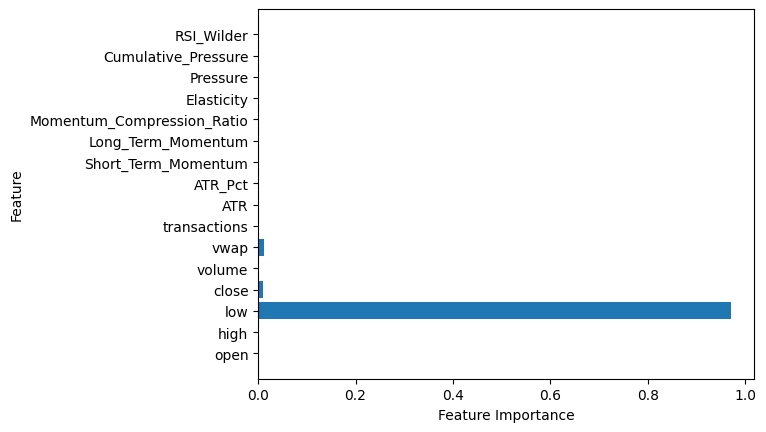

Test MSE: 0.7037336880261493


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 假设X和y已经是预处理并准备好的数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建随机森林模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X_train, y_train)

# 获取特征重要性
importances = rf.feature_importances_

# 显示特征重要性
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

# 预测并计算MSE
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


## DS ##

In [ ]:
def calculate_missing_features(df):
    """
    计算缺失的特征
    """
    # 1. 分形维度计算


    # 3. 赫斯特指数计算
    def calculate_hurst(price_series, lags=range(2, 20)):
        tau = []
        for lag in lags:
            tau.append(np.std(price_series.diff(lag)))
        return np.polyfit(np.log(lags), np.log(tau), 1)[0]

    # 使用滚动窗口计算特征
    window = 100  # 可以调整窗口大小

    # 计算分形维度


    # 计算赫斯特指数
    df['hurst'] = df['close'].rolling(window).apply(
        lambda x: calculate_hurst(x)
    )

    return df
calculate_missing_features(df)

,open,high,low,close,volume,vwap,transactions,ATR,ATR_Pct,support,...,Elasticity,Pressure,Cumulative_Pressure,RSI_Wilder,distance,vol_shock,volume_ratio,momentum,fractal_dim,hurst
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-30 00:00:00,2623.80,2624.77,2623.80,2623.87,3,2624.1467,3,NaN,NaN,NaN,...,0.072165,3,3,NaN,6.117117,NaN,NaN,NaN,NaN,NaN
2024-12-30 00:01:00,2624.21,2624.21,2624.05,2624.05,3,2624.1300,3,NaN,NaN,NaN,...,0.257732,-3,0,NaN,6.171171,NaN,NaN,NaN,NaN,NaN
2024-12-30 00:02:00,2624.03,2624.47,2624.03,2624.47,2,2624.2500,2,NaN,NaN,NaN,...,0.690722,2,2,NaN,6.297297,NaN,NaN,NaN,NaN,NaN
2024-12-30 00:03:00,2624.60,2624.60,2624.03,2624.58,3,2624.4033,3,NaN,NaN,NaN,...,0.804124,-3,-1,NaN,6.330330,NaN,NaN,NaN,NaN,NaN
2024-12-30 00:04:00,2624.42,2624.72,2624.42,2624.72,2,2624.5700,2,NaN,NaN,NaN,...,0.948454,2,1,NaN,6.372372,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:55:00,2606.62,2606.73,2606.62,2606.73,2,2606.6750,2,0.401903,0.015418,2599.485954,...,1.000000,2,-1196,68.918633,0.969970,1.031419,0.731707,0.000200,1.0,0.602547
2024-12-30 23:56:00,2606.55,2606.83,2606.55,2606.83,3,2606.7200,3,0.393195,0.015083,2599.573070,...,1.000000,3,-1193,70.274296,1.000000,1.012206,1.097561,0.000157,1.0,0.605327
2024-12-30 23:57:00,2606.67,2606.78,2606.59,2606.78,3,2606.6800,3,0.382253,0.014664,2599.682282,...,0.967320,3,-1190,68.661717,0.984985,0.986718,1.097561,0.000173,1.0,0.609425


In [ ]:
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# 计算5分钟和60分钟滚动波动率
df['volatility'] = df['log_return'].rolling(window=5).std()

In [ ]:
df

,open,high,low,close,volume,vwap,transactions,ATR,ATR_Pct,support,...,Cumulative_Pressure,RSI_Wilder,distance,vol_shock,volume_ratio,momentum,fractal_dim,hurst,log_return,volatility_5m
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-30 00:00:00,2623.80,2624.77,2623.80,2623.87,3,2624.1467,3,NaN,NaN,NaN,...,3,NaN,6.117117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30 00:01:00,2624.21,2624.21,2624.05,2624.05,3,2624.1300,3,NaN,NaN,NaN,...,0,NaN,6.171171,NaN,NaN,NaN,NaN,NaN,0.000069,NaN
2024-12-30 00:02:00,2624.03,2624.47,2624.03,2624.47,2,2624.2500,2,NaN,NaN,NaN,...,2,NaN,6.297297,NaN,NaN,NaN,NaN,NaN,0.000160,NaN
2024-12-30 00:03:00,2624.60,2624.60,2624.03,2624.58,3,2624.4033,3,NaN,NaN,NaN,...,-1,NaN,6.330330,NaN,NaN,NaN,NaN,NaN,0.000042,NaN
2024-12-30 00:04:00,2624.42,2624.72,2624.42,2624.72,2,2624.5700,2,NaN,NaN,NaN,...,1,NaN,6.372372,NaN,NaN,NaN,NaN,NaN,0.000053,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:55:00,2606.62,2606.73,2606.62,2606.73,2,2606.6750,2,0.401903,0.015418,2599.485954,...,-1196,68.918633,0.969970,1.031419,0.731707,0.000200,1.0,0.602547,0.000069,0.000045
2024-12-30 23:56:00,2606.55,2606.83,2606.55,2606.83,3,2606.7200,3,0.393195,0.015083,2599.573070,...,-1193,70.274296,1.000000,1.012206,1.097561,0.000157,1.0,0.605327,0.000038,0.000039
2024-12-30 23:57:00,2606.67,2606.78,2606.59,2606.78,3,2606.6800,3,0.382253,0.014664,2599.682282,...,-1190,68.661717,0.984985,0.986718,1.097561,0.000173,1.0,0.609425,-0.000019,0.000033


In [ ]:
import pandas as pd
from scipy import stats

def dynamic_levels(data, window=30, confidence=0.95):
    """
    返回带置信区间的动态支撑阻力位
    """
    # 计算基础水平
    support_base = data['low'].rolling(window).min()
    resist_base = data['high'].rolling(window).max()

    # 计算置信区间的辅助函数
    def calc_interval(row):
        if pd.isna(row['base']) or pd.isna(row['std']):
            return pd.NA, pd.NA
        ci = stats.t.interval(confidence, window-1, loc=row['base'], scale=row['std'])
        return ci[0], ci[1]

    # 合并基础和标准差，逐行应用 calc_interval 函数
    support_data = pd.DataFrame({
        'base': support_base,
        'std': data['low'].rolling(window).std()
    })
    resist_data = pd.DataFrame({
        'base': resist_base,
        'std': data['high'].rolling(window).std()
    })

    support_ci = support_data.apply(calc_interval, axis=1)
    resist_ci = resist_data.apply(calc_interval, axis=1)

    # 处理结果，分解为上下限
    support_ci_low = support_ci.apply(lambda x: x[0])
    support_ci_high = support_ci.apply(lambda x: x[1])

    resist_ci_low = resist_ci.apply(lambda x: x[0])
    resist_ci_high = resist_ci.apply(lambda x: x[1])

    return {
        'support': (support_base, (support_ci_low, support_ci_high)),
        'resistance': (resist_base, (resist_ci_low, resist_ci_high))
    }

# 示例使用
levels = dynamic_levels(df)
current_support = levels['support'][0].iloc[-1]
current_resistance = levels['resistance'][0].iloc[-1]
support_ci_low, support_ci_high = levels['support'][1][0].iloc[-1], levels['support'][1][1].iloc[-1]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

class BreakProbabilityModel:
    def __init__(self):
        self.model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
        self.features = ['distance', 'volatility', 'volume_ratio', 'momentum']

    def calculate_features(self, data):
        """
        计算突破相关特征
        """
        # 当前价格到支撑/阻力的距离（标准化）
        data['distance'] = (data['close'] - current_support) / (current_resistance - current_support)

        # 波动率冲击
        data['vol_shock'] = data['ATR_Pct'] / data['ATR_Pct'].rolling(50).mean()

        # 量能比率
        data['volume_ratio'] = data['volume'] / data['volume'].rolling(30).mean()

        # 动量强度
        data['momentum'] = data['close'].pct_change(5)
        return data

    def fit(self, X, y):
        self.model.fit(X[self.features], y)

    def explain_break(self, X):
        # 计算特征重要性
        result = permutation_importance(self.model, X[self.features], X['break'], n_repeats=10)
        return {f: i for f, i in zip(self.features, result.importances_mean)}

    def monte_carlo_simulation(self, current_state, n_sims=1000):
        """
        蒙特卡洛模拟突破概率
        """
        paths = []
        for _ in range(n_sims):
            # 基于当前波动率和动量生成路径
            path = current_state['close'] * np.exp(np.cumsum(
                np.random.normal(current_state['momentum'], current_state['volatility'], 10)
            ))
            paths.append(path)
        # 计算突破次数
        break_count = sum([max(path) > current_resistance or min(path) < current_support for path in paths])
        return break_count / n_sims

# 初始化模型
bpm = BreakProbabilityModel()
data = bpm.calculate_features(df)


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def calculate_fractal_dim(price_series, box_sizes=np.logspace(1, 3, 10)):
    counts = []
    for box_size in box_sizes:
        box_count = (max(price_series) - min(price_series)) / box_size
        counts.append(box_count)

    log_box_sizes = np.log(box_sizes)
    log_counts = np.log(counts)

    model = LinearRegression()
    model.fit(log_box_sizes.reshape(-1, 1), log_counts)
    return model




In [ ]:
m1

array([-1.])

In [ ]:
import pandas as pd

# 假设你已经有了这些特征的值


In [ ]:
df


,open,high,low,close,volume,vwap,transactions,ATR,ATR_Pct,support,...,Long_Term_Momentum,Momentum_Compression_Ratio,Elasticity,Pressure,Cumulative_Pressure,RSI_Wilder,distance,vol_shock,volume_ratio,momentum
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-30 00:00:00,2623.80,2624.77,2623.80,2623.87,3,2624.1467,3,NaN,NaN,NaN,...,NaN,NaN,0.072165,3,3,NaN,6.117117,NaN,NaN,NaN
2024-12-30 00:01:00,2624.21,2624.21,2624.05,2624.05,3,2624.1300,3,NaN,NaN,NaN,...,NaN,NaN,0.257732,-3,0,NaN,6.171171,NaN,NaN,NaN
2024-12-30 00:02:00,2624.03,2624.47,2624.03,2624.47,2,2624.2500,2,NaN,NaN,NaN,...,NaN,NaN,0.690722,2,2,NaN,6.297297,NaN,NaN,NaN
2024-12-30 00:03:00,2624.60,2624.60,2624.03,2624.58,3,2624.4033,3,NaN,NaN,NaN,...,NaN,NaN,0.804124,-3,-1,NaN,6.330330,NaN,NaN,NaN
2024-12-30 00:04:00,2624.42,2624.72,2624.42,2624.72,2,2624.5700,2,NaN,NaN,NaN,...,NaN,NaN,0.948454,2,1,NaN,6.372372,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:55:00,2606.62,2606.73,2606.62,2606.73,2,2606.6750,2,0.401903,0.015418,2599.485954,...,0.75,0.693333,1.000000,2,-1196,68.918633,0.969970,1.031419,0.731707,0.000200
2024-12-30 23:56:00,2606.55,2606.83,2606.55,2606.83,3,2606.7200,3,0.393195,0.015083,2599.573070,...,1.37,0.299270,1.000000,3,-1193,70.274296,1.000000,1.012206,1.097561,0.000157
2024-12-30 23:57:00,2606.67,2606.78,2606.59,2606.78,3,2606.6800,3,0.382253,0.014664,2599.682282,...,1.02,0.441176,0.967320,3,-1190,68.661717,0.984985,0.986718,1.097561,0.000173


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

class NextLevelPredictor:
    def __init__(self):
        self.support_model = GradientBoostingRegressor()
        self.resist_model = GradientBoostingRegressor()
        self.features = ['RSI_Wilder', 'vol_shock', 'Pressure', 'ATR']

    def fit(self, X, y_support, y_resist):
        self.support_model.fit(X[self.features], y_support)
        self.resist_model.fit(X[self.features], y_resist)

    def predict_next_level(self, X, break_direction):
        if break_direction == 'up':
            return self.resist_model.predict(X[self.features])[0] * 1.02  # 2%过滤
        elif break_direction == 'down':
            return self.support_model.predict(X[self.features])[0] * 0.98
        else:
            return None



In [ ]:
def break_significance_test(data, level_type='support'):
    """
 使用Wilcoxon符号秩检验验证突破的有效性
    """
    if level_type == 'support':
        test_data = data[data['close'] < current_support]
        test_values = current_support - test_data['close']
    else:
        test_data = data[data['close'] > current_resistance]
        test_values = test_data['close'] - current_resistance

    # 检验价格是否持续停留在突破区域
    return stats.wilcoxon(test_values).pvalue < 0.05

# 示例
is_valid_break = break_significance_test(df[-30:], 'resistance')

In [ ]:
def price_distribution_test(data, level, window=30):
    """
 使用KS检验比较当前价格分布与历史分布的差异
    """
    historical = data['close'].rolling(window).apply(lambda x: stats.ks_2samp(x, data['close'].iloc[-window:])[0])
    current_stat = stats.ks_2samp(data['close'].iloc[-window:], data['close'])[0]
    return current_stat > np.percentile(historical, 95)

# 检测当前价格分布是否发生显著变化
distribution_changed = price_distribution_test(df, current_support)

/opt/anaconda3/envs/en1/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
class BreakAnalysisSystem:
    def __init__(self):
        self.levels = dynamic_levels(df)
        self.prob_model = BreakProbabilityModel()
        self.next_level_model = NextLevelPredictor()

    def run_analysis(self):
        # 计算突破概率
        current_state = {
            'close': df['close'].iloc[-1],
            'momentum': df['momentum'].iloc[-1],
            'volatility': df['volatility'].iloc[-1]
        }
        prob_break = self.prob_model.monte_carlo_simulation(current_state)

        # 统计检验
        significance = break_significance_test(df[-30:])

        # 生成解释
        explanation = self.generate_explanation(prob_break, significance)

        # 预测下一级位
        if prob_break > 0.7:
            direction = 'up' if df['close'].iloc[-1] > current_resistance else 'down'
            next_level = self.next_level_model.predict_next_level(df.iloc[-1], direction)
        else:
            next_level = None

        return {
            'current_support': current_support,
            'current_resistance': current_resistance,
            'break_probability': prob_break,
            'statistical_significance': significance,
            'next_level': next_level,
            'explanation': explanation
        }

    def generate_explanation(self, prob, sig):
        factors = []
        if df['vol_shock'].iloc[-1] > 2:
            factors.append("当前波动率是平均水平的2倍以上")
        if df['volume_ratio'].iloc[-1] > 1.5:
            factors.append("成交量超过近期均值50%")
        if df['momentum'].iloc[-1] > 0.03:
            factors.append("存在强劲的短期动量")

        explanation = f"突破概率{prob:.0%}主要由以下因素驱动：\n" + "\n".join(factors)
        if sig:
            explanation += "\n统计检验确认突破有效性"
        else:
            explanation += "\n当前突破尚未通过统计显著性检验"
        return explanation

# 执行分析
bas = BreakAnalysisSystem()
result = bas.run_analysis()
print(result)

{'current_support': np.float64(2603.5), 'current_resistance': np.float64(2606.83), 'break_probability': np.float64(0.173), 'statistical_significance': np.False_, 'next_level': None, 'explanation': '突破概率17%主要由以下因素驱动：\n\n当前突破尚未通过统计显著性检验'}


## DS 2 ##

In [16]:
import cuml
import cudf
cuml.__version__

'24.12.00'

In [15]:
from scipy.stats import linregress

def calculate_features(df):
    """
    计算支撑阻力相关的特征
    """
    # 1. 分形维度
    def fractal_dim(series, window=100):
        return series.rolling(window).apply(
            lambda x: linregress(np.log(range(1, len(x)+1)), np.log(x)).slope
        )

    # 2. 赫斯特指数
    def hurst_exponent(series, window=100):
        return series.rolling(window).apply(
            lambda x: linregress(np.log(range(1, len(x)+1)), np.log(x)).slope
        )

    # 3. 压力值
    def pressure(price, volume):
        return np.where(price.diff() > 0, volume, -volume).cumsum()

    # 4. 波动率聚类
    def vol_cluster(returns, window=20):
        return (returns.abs() > returns.rolling(window).mean()).rolling(3).sum()

    # 5. ATR（真实波动幅度）
    def atr(df, window=14):
        high = df['high']
        low = df['low']
        close = df['close']
        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
        return tr.rolling(window).mean()

    # 应用特征计算
    df['fractal_dim'] = fractal_dim(df['close'])
    df['hurst'] = hurst_exponent(df['close'])
    df['pressure'] = pressure(df['close'], df['volume'])
    df['vol_cluster'] = vol_cluster(df['close'].pct_change())
    df['atr'] = atr(df)

    return df

# 示例使用
df = calculate_features(df)

In [21]:
df

,open,high,low,close,volume,vwap,transactions,RSI_Wilder,fractal_dim,hurst,pressure,vol_cluster,atr
timestamp,,,,,,,,,,,,,
2024-12-30 00:00:00,2623.80,2624.77,2623.80,2623.87,3,2624.1467,3,NaN,NaN,NaN,-3,NaN,NaN
2024-12-30 00:01:00,2624.21,2624.21,2624.05,2624.05,3,2624.1300,3,NaN,NaN,NaN,0,NaN,NaN
2024-12-30 00:02:00,2624.03,2624.47,2624.03,2624.47,2,2624.2500,2,NaN,NaN,NaN,2,0.0,NaN
2024-12-30 00:03:00,2624.60,2624.60,2624.03,2624.58,3,2624.4033,3,NaN,NaN,NaN,5,0.0,NaN
2024-12-30 00:04:00,2624.42,2624.72,2624.42,2624.72,2,2624.5700,2,NaN,NaN,NaN,7,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:55:00,2606.62,2606.73,2606.62,2606.73,2,2606.6750,2,68.918633,-0.000270,-0.000270,-28840,3.0,0.451429
2024-12-30 23:56:00,2606.55,2606.83,2606.55,2606.83,3,2606.7200,3,70.274296,-0.000262,-0.000262,-28837,3.0,0.445000
2024-12-30 23:57:00,2606.67,2606.78,2606.59,2606.78,3,2606.6800,3,68.661717,-0.000258,-0.000258,-28840,2.0,0.379286


In [32]:
df= df.dropna()

In [44]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

def calculate_fibonacci_levels(high, low):
    """
    计算斐波那契回撤水平
    :param high: 最高价
    :param low: 最低价
    :return: 包含斐波那契回撤水平的字典
    """
    diff = high - low
    return {
        'support_382': high - diff * 0.382,  # 38.2% 回撤
        'support_500': high - diff * 0.500,  # 50% 回撤
        'support_618': high - diff * 0.618,  # 61.8% 回撤
        'resistance_1382': low + diff * 1.382,  # 138.2% 扩展
        'resistance_1618': low + diff * 1.618  # 161.8% 扩展
    }

class SupportResistanceModel:
    def __init__(self):
        self.support_model = XGBRegressor()  # 支撑位模型
        self.resist_model = XGBRegressor()  # 阻力位模型
        self.features = ['fractal_dim', 'vol_cluster', 'pressure', 'hurst', 'atr', 'RSI_Wilder']  # 特征

    def fit(self, X, y_support, y_resist):
        """训练模型"""
        self.support_model.fit(X[self.features], y_support)
        self.resist_model.fit(X[self.features], y_resist)

    def predict(self, X, break_direction):
        """预测支撑位或阻力位"""
        if break_direction == 'up':
            return self.resist_model.predict(X[self.features])[0] * 1.02  # 2% 过滤
        elif break_direction == 'down':
            return self.support_model.predict(X[self.features])[0] * 0.98
        else:
            raise ValueError("break_direction 必须是 'up' 或 'down'")

# 示例使用
# 假设 df 是包含特征和目标值的数据框
# 确保 df 包含以下列：'fractal_dim', 'vol_cluster', 'pressure', 'hurst', 'atr', 'RSI_Wilder', 'low', 'high'

# 计算斐波那契回撤水平
high = df['high'].max()
low = df['low'].min()
fib_levels = calculate_fibonacci_levels(high, low)

# 初始化机器学习模型
model = SupportResistanceModel()

# 准备数据
X = df[['fractal_dim', 'vol_cluster', 'pressure', 'hurst', 'atr', 'RSI_Wilder']].iloc[:-1]  # 删除最后一行
y_support = df['low'].shift(-1).dropna()  # 删除 NaN
y_resist = df['high'].shift(-1).dropna()  # 删除 NaN

# 划分数据集
train_size = int(len(X) * 0.8)  # 80% 训练集，20% 测试集
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_support_train, y_support_test = y_support.iloc[:train_size], y_support.iloc[train_size:]
y_resist_train, y_resist_test = y_resist.iloc[:train_size], y_resist.iloc[train_size:]

# 训练模型
model.fit(X_train, y_support_train, y_resist_train)

# 预测支撑位和阻力位
next_support = model.predict(X_test.iloc[-1:], 'down')
next_resistance = model.predict(X_test.iloc[-1:], 'up')

# 结合斐波那契回撤和机器学习预测
final_support = (next_support + fib_levels['support_618']) / 2  # 取平均值
final_resistance = (next_resistance + fib_levels['resistance_1382']) / 2  # 取平均值

print(f"最终支撑位: {final_support}, 最终阻力位: {final_resistance}")


# 评估模型性能
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred):
    """评估模型性能"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    directional_accuracy = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))  # 方向准确率
    hit_rate = np.mean(np.abs((y_true - y_pred) / y_true) < 0.01)  # 命中率（误差 < 1%）
    return {
        'MSE': mse,
        'MAE': mae,
        'Directional Accuracy': directional_accuracy,
        'Hit Rate': hit_rate
    }

# 评估支撑位预测
support_metrics = evaluate_model(y_support_test, y_support_pred)
print("支撑位预测性能:", support_metrics)

# 评估阻力位预测
resist_metrics = evaluate_model(y_resist_test, y_resist_pred)
print("阻力位预测性能:", resist_metrics)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


支撑位预测性能: {'MSE': 1.1860044327770687, 'MAE': 0.6755878620461172, 'Directional Accuracy': 0.5026277823577906, 'Hit Rate': 1.0}
阻力位预测性能: {'MSE': 1.5595703173172517, 'MAE': 0.8721608904454752, 'Directional Accuracy': 0.49010717230008244, 'Hit Rate': 1.0}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [34]:
len(y_support)

97042

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred):
    """
    评估模型性能
    :param y_true: 真实值 (pd.Series 或 np.array)
    :param y_pred: 预测值 (pd.Series 或 np.array)
    :return: 包含各项指标的字典
    """
    # 计算均方误差 (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # 计算平均绝对误差 (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # 计算方向准确率 (Directional Accuracy)
    # 比较真实值和预测值的变化方向
    directional_accuracy = np.mean(np.sign(y_true.diff().dropna()) == np.sign(y_pred.diff().dropna()))

    # 计算命中率 (Hit Rate)
    # 预测值与真实值的误差在 ±1% 范围内视为命中
    hit_rate = np.mean(np.abs((y_true - y_pred) / y_true) < 0.01)

    return {
        'MSE': mse,
        'MAE': mae,
        'Directional Accuracy': directional_accuracy,
        'Hit Rate': hit_rate
    }

In [42]:
# 假设 y_true 和 y_pred 是真实值和预测值
y_true = df['low'].iloc[-100:]  # 真实支撑位
y_pred = model.support_model.predict(X.iloc[-100:])  # 预测支撑位

# 评估模型性能
metrics = evaluate_model(y_true, y_pred)
print("支撑位预测性能:", metrics)

AttributeError: 'numpy.ndarray' object has no attribute 'diff'

In [37]:
def predict_next_level(df, model, break_direction):
    """预测下一个支撑位或阻力位"""
    current_features = df.iloc[-1][model.features].to_frame().T  # 包含 RSI
    return model.predict(current_features, break_direction)

# 示例使用
next_support = predict_next_level(df, model, 'down')
next_resistance = predict_next_level(df, model, 'up')
print(f"下一个支撑位: {next_support}, 下一个阻力位: {next_resistance}")

下一个支撑位: 2597.9115722656247, 下一个阻力位: 2707.4896435546875


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:36:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:36:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:36:47] WARNING: /workspace/src

In [38]:
def get_feature_importance(model):
    """获取特征重要性"""
    support_importance = dict(zip(model.features, model.support_model.feature_importances_))
    resist_importance = dict(zip(model.features, model.resist_model.feature_importances_))
    return {
        'support_importance': support_importance,
        'resist_importance': resist_importance
    }

# 示例使用
importance = get_feature_importance(model)
print("支撑位模型特征重要性:", importance['support_importance'])
print("阻力位模型特征重要性:", importance['resist_importance'])

支撑位模型特征重要性: {'fractal_dim': 0.006203234, 'vol_cluster': 0.00045720002, 'pressure': 0.98758286, 'hurst': 0.0, 'atr': 0.0032008432, 'RSI_Wilder': 0.0025558756}
阻力位模型特征重要性: {'fractal_dim': 0.0061799986, 'vol_cluster': 0.00045532867, 'pressure': 0.98822856, 'hurst': 0.0, 'atr': 0.0032511805, 'RSI_Wilder': 0.0018849501}


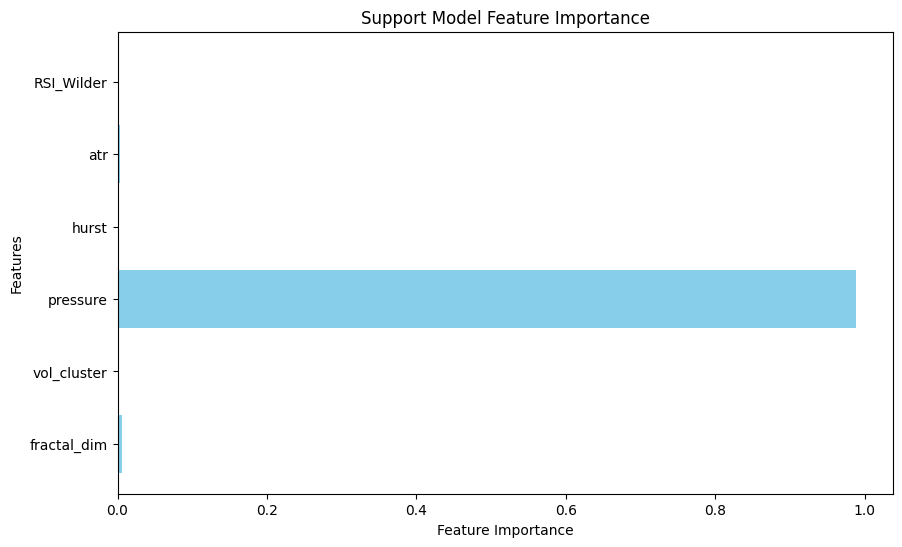

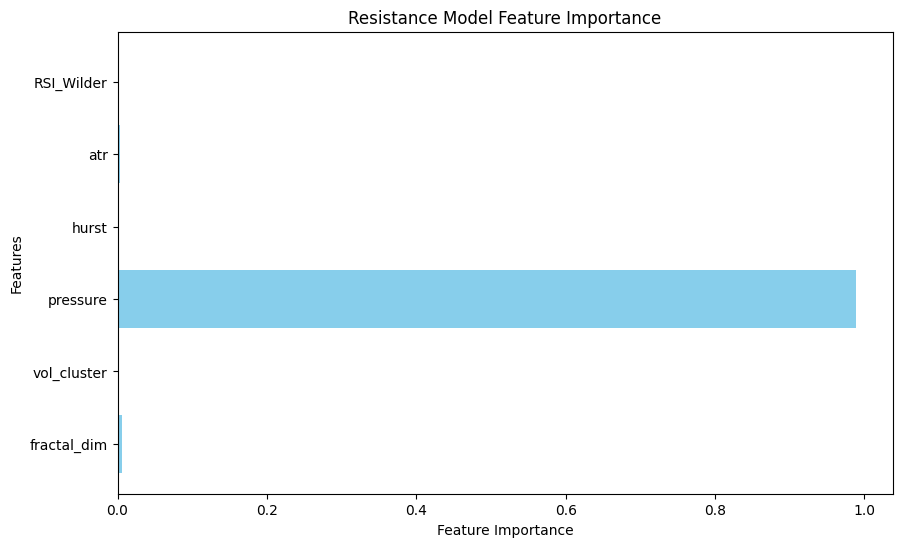

In [39]:
import matplotlib.pyplot as plt

def plot_feature_importance(importance, title):
    """绘制特征重要性图"""
    features = list(importance.keys())
    values = list(importance.values())

    plt.figure(figsize=(10, 6))
    plt.barh(features, values, color='skyblue')
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.show()

# 示例使用
plot_feature_importance(importance['support_importance'], 'Support Model Feature Importance')
plot_feature_importance(importance['resist_importance'], 'Resistance Model Feature Importance')

 ## FIB ##

In [52]:
df

,open,high,low,close,volume,vwap,transactions,ATR,ATR_Pct,RSI_Wilder,local_high,local_low,fib_23_6,fib_38_2,fib_50,fib_61_8
timestamp,,,,,,,,,,,,,,,,
2024-12-30 00:15:00,2624.44,2624.44,2623.72,2623.72,3,2624.0267,3,0.421880,0.016079,45.498263,2624.87,2622.5,2623.05932,2623.40534,2623.685,2623.96466
2024-12-30 00:16:00,2623.82,2624.17,2623.34,2623.34,3,2623.7767,3,0.451032,0.017193,39.458535,2624.87,2622.5,2623.05932,2623.40534,2623.685,2623.96466
2024-12-30 00:17:00,2623.30,2623.32,2623.30,2623.32,2,2623.3100,2,0.421672,0.016074,39.163862,2624.87,2622.5,2623.05932,2623.40534,2623.685,2623.96466
2024-12-30 00:18:00,2623.73,2623.73,2622.70,2623.57,4,2623.3250,4,0.465124,0.017729,44.721023,2624.87,2622.5,2623.05932,2623.40534,2623.685,2623.96466
2024-12-30 00:19:00,2623.65,2623.73,2622.50,2623.73,3,2623.2933,3,0.519758,0.019810,47.995181,2624.87,2622.5,2623.05932,2623.40534,2623.685,2623.96466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:41:00,2605.86,2605.86,2605.46,2605.46,3,2605.6067,3,0.342373,0.013141,55.627086,2606.73,2603.5,2604.26228,2604.73386,2605.115,2605.49614
2024-12-30 23:42:00,2605.83,2605.83,2605.66,2605.76,3,2605.7500,3,0.344346,0.013215,60.143241,2606.83,2603.5,2604.28588,2604.77206,2605.165,2605.55794
2024-12-30 23:43:00,2605.69,2605.69,2604.60,2605.62,3,2605.3033,3,0.402607,0.015451,57.216632,2606.83,2603.5,2604.28588,2604.77206,2605.165,2605.55794


In [57]:
df.index = pd.to_datetime(df.index)
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [61]:
import pandas as pd
import numpy as np

# 假设 'data' 已经是你的黄金数据，包含 'time', 'high', 'low', 'close', 'RSI', 等列


# 计算局部的高点和低点（例如，3天内的最高点和最低点）
window_size = 30  # 设置窗口大小为3，可以根据需求调整

# 识别局部高点和低点
df['local_high'] = df['high'].rolling(window=window_size, center=True).max()
df['local_low'] = df['low'].rolling(window=window_size, center=True).min()
df = df.dropna()
# 计算局部波动的斐波那契回撤
def calculate_fibonacci_for_local_wave(row):
    if pd.notna(row['local_high']) and pd.notna(row['local_low']):
        max_price = row['local_high']
        min_price = row['local_low']
        return pd.Series({
            'fib_23_6': min_price + (max_price - min_price) * 0.236,
            'fib_38_2': min_price + (max_price - min_price) * 0.382,
            'fib_50': min_price + (max_price - min_price) * 0.5,
            'fib_61_8': min_price + (max_price - min_price) * 0.618
        })
    return pd.Series([None, None, None, None])

# 应用到每一行数据
df[['fib_23_6', 'fib_38_2', 'fib_50', 'fib_61_8']] = df.apply(calculate_fibonacci_for_local_wave, axis=1)

# 重采样：按不同时间框架（如15分钟、1小时、4小时、日线、周线）重采样
resampled_data_frames = {
    '15m': df.resample('15T'),
    '1h': df.resample('1H'),
    '4h': df.resample('4H'),
    '1d': df.resample('1D'),
    '1w': df.resample('1W')
}

import pandas as pd
import numpy as np

# ... (previous code) ...

# 处理每个重采样的数据
for key, rdf in resampled_data_frames.items():
    rdf_agg = rdf.agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'RSI_Wilder': 'last',
        'local_high': 'max',  # Include local_high in aggregation
        'local_low': 'min'   # Include local_low in aggregation
    })
    # Apply the function and ensure the result has the correct columns
    fib_results = rdf_agg.apply(calculate_fibonacci_for_local_wave, axis=1)
    fib_results.columns = ['fib_23_6', 'fib_38_2', 'fib_50', 'fib_61_8']  # Ensure correct column names
    rdf_agg = pd.concat([rdf_agg, fib_results], axis=1)  # Concatenate results

    print(f"{key} data sample:")
    print(rdf_agg[['fib_23_6', 'fib_38_2', 'fib_50', 'fib_61_8']].tail())


<ipython-input-61-9f474dc7dc35>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  '15m': df.resample('15T'),
<ipython-input-61-9f474dc7dc35>:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  '1h': df.resample('1H'),
<ipython-input-61-9f474dc7dc35>:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  '4h': df.resample('4H'),


ValueError: Length mismatch: Expected axis has 8 elements, new values have 4 elements